In [1]:
%matplotlib inline

import torch
import re
from torch.utils.data import DataLoader
import random
import time

In [2]:
label_class_map = {'+': 0, '-': 1, 'o': 2}

In [3]:
positive_samples = []
negative_samples = []
neutral_samples = []

with open('protocols/labelled/only_lockdown.csv', 'r') as f:
    next(f)
    for line in f:
        col_vals = re.split('\\t', line)
        opinion = col_vals[6]
        sentence = col_vals[13]
        if opinion == '+':
            positive_samples.append(sentence)
        elif opinion == '-':
            negative_samples.append(sentence)
        elif opinion == 'o':
            neutral_samples.append(sentence)

all_samples = positive_samples + negative_samples + neutral_samples

In [4]:
def get_train_test_split_proportional(ratio=0.8, shuffle=True):
    pos = positive_samples.copy()
    neg = negative_samples.copy()
    neut = neutral_samples.copy()
    if shuffle:
        random.shuffle(pos)
        random.shuffle(neg)
        random.shuffle(neut)
    train_samples = [(0,s) for s in pos[:int(ratio*len(pos))]] + \
            [(1,s) for s in neg[:int(ratio*len(neg))]] + \
            [(2,s) for s in neut[:int(ratio*len(neut))]]
    test_samples = [(0,s) for s in pos[int(ratio*len(pos)):]] + \
            [(1,s) for s in neg[int(ratio*len(neg)):]] + \
            [(2,s) for s in neut[int(ratio*len(neut)):]]
    return train_samples, test_samples

def get_train_test_split_even(per_class=50, shuffle=True):
    pos = positive_samples.copy()
    neg = negative_samples.copy()
    neut = neutral_samples.copy()
    if shuffle:
        random.shuffle(pos)
        random.shuffle(neg)
        random.shuffle(neut)
    train_samples = [(0,s) for s in pos[:per_class]] + \
            [(1,s) for s in neg[:per_class]] + \
            [(2,s) for s in neut[:per_class]]
    test_samples = [(0,s) for s in pos[per_class:]] + \
            [(1,s) for s in neg[per_class:]] + \
            [(2,s) for s in neut[per_class:]]
    return train_samples, test_samples

Prepare data processing pipelines
---------------------------------

In [5]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import spacy
spacy.load('de_dep_news_trf')

tokenizer = get_tokenizer('spacy', language='de_dep_news_trf')
counter = Counter()
for line in all_samples:
    counter.update(tokenizer(line))
vocab = Vocab(counter, min_freq=0)
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: label_class_map.get(x)

Generate data batch and iterator
--------------------------------

In [9]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    class_list, text_list, offsets = [], [], [0]
    for (_class, _text) in batch:
         class_list.append(_class)
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(class_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

Define the model
----------------

In [10]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

Initiate an instance
--------------------

In [11]:
import time

def train(model, dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

Split the dataset and run the model
-----------------------------------

In [49]:
from torch.utils.data.dataset import random_split
# Hyperparameters
EPOCHS = 20 # epoch
LR = 5  # learning rate
BATCH_SIZE = 16 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
num_train = int(len(train_ds) * 0.95)
split_train_, split_valid_ = \
    random_split(train_ds, [num_train, len(train_ds) - num_train])

# train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
#                               shuffle=True, collate_fn=collate_batch)
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    # accu_val = evaluate(valid_dataloader)
    accu_val = evaluate(train_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)


-----------------------------------------------------------
| end of epoch   1 | time:  0.10s | valid accuracy    0.411 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  0.10s | valid accuracy    0.481 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  0.09s | valid accuracy    0.519 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  0.09s | valid accuracy    0.626 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  0.09s | valid accuracy    0.689 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  0.09s |

In [50]:
validation_set = [tuple for tuple in valid_dataloader]

Evaluate the model with test dataset
------------------------------------

In [14]:
def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        pred_pos = 0
        pred_neg = 0
        pred_neut = 0
        for idx, (label, text, offsets) in enumerate(dataloader):
            label_probs = model(text, offsets)
            predicted_label = label_probs.argmax(1)
            c = Counter(predicted_label.tolist())
            pred_pos += c.get(0, 0)
            pred_neg += c.get(1, 0)
            pred_neut += c.get(2, 0)
            loss = criterion(label_probs, label)
            total_acc += (predicted_label == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count, pred_pos, pred_neg, pred_neut
# print('Checking the results of test dataset.')
# accu_test, pos, neg, neut = evaluate(model, test_dataloader)
# print('test accuracy {:8.3f}'.format(accu_test))


In [52]:
# pos, neg, neut


(30, 106, 86)

In [35]:
# RUN MULTIPLE TIMES

accuracies = []
runs = 50
for i in range(runs):
    train_ds, test_ds = get_train_test_split_even(90, True)
    num_class = len(label_class_map)
    vocab_size = len(vocab)
    emsize = 64
    model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

    # Hyperparameters
    EPOCHS = 20 # epoch
    LR = 5  # learning rate
    BATCH_SIZE = 16 # batch size for training

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    total_accu = None
    # num_train = int(len(train_ds) * 0.95)
    # split_train_, split_valid_ = random_split(train_ds, [num_train, len(train_ds) - num_train])

    train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                                  shuffle=True, collate_fn=collate_batch)
    test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE,
                                 shuffle=True, collate_fn=collate_batch)

    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        train(model, train_dataloader)
        accu_val, pred_pos, pred_neg, pred_neut = evaluate(model, train_dataloader)
        if total_accu is not None and total_accu > accu_val:
          scheduler.step()
        else:
           total_accu = accu_val
        print('-' * 59)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid accuracy {:8.3f} '.format(epoch, time.time() - epoch_start_time, accu_val))
        print('-' * 59)
    accu_test, pos, neg, neut = evaluate(model, test_dataloader)
    accuracies.append(accu_test)

-----------------------------------------------------------
| end of epoch   1 | time:  0.12s | valid accuracy    0.337 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  0.10s | valid accuracy    0.511 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  0.10s | valid accuracy    0.426 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  0.09s | valid accuracy    0.648 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  0.09s | valid accuracy    0.674 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  0.09s |

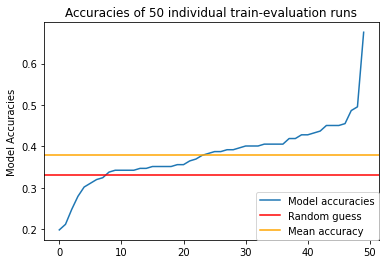

In [39]:
# plot accuracies
import matplotlib.pyplot as plt
plt.plot(sorted(accuracies), label='Model accuracies')
plt.axhline(y=0.33, color='r', linestyle='-', label='Random guess')
plt.axhline(y=sum(accuracies)/runs, color='orange', linestyle='-', label='Mean accuracy')
plt.ylabel('Model Accuracies')
plt.title(f"Accuracies of {runs} individual train-evaluation runs")
plt.legend(loc="lower right", borderaxespad=0)
plt.savefig('plots/accuracies.png')
plt.show()


Test on a random sample
---------------------


In [53]:
opinion_label = {0: "+",
                 1: "-",
                 2: "o"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()

ex_text_str = "Alle können jetzt durch diesen Lockdown kom­men, weil die Coronakurzarbeit dafür adaptiert wurde."

print("The opinion is %s" %opinion_label[predict(ex_text_str, text_pipeline)])

The opinion is +
